In [2]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np
import portfolioGeneration
import portfolio
import dataAck
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")
from IPython.display import display


In [3]:
def getUniqueModelsForTicker(tickerToTrade):
    allModels = portfolio.getModels(tickerToTrade, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    for i in range(len(uniqueModels)):
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    return uniqueModels

In [4]:
def getAllUniqueModels():
    allModels = portfolio.getModels(ticker=None, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    uniqueModelsToKeep = []
    for i in range(len(uniqueModels)):
        if uniqueEntities[i]["SHARPE"] > 1.0 and uniqueEntities[i]["TREYNOR"] > 0.0\
            and uniqueEntities[i]["ACTIVITY"] > 0.7 and uniqueEntities[i]["ROLLING SHARPE BETA"] < 0.2:
            uniqueModelsToKeep.append(uniqueModels[i])
        else:
            continue
            
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    print("MODELS KEPT:", len(uniqueModelsToKeep))
    return uniqueModelsToKeep

In [5]:
# uniqueModels = getAllUniqueModels()

In [6]:
uniqueModels = getUniqueModelsForTicker("VGK") + getUniqueModelsForTicker("XME")

***ORIGINAL MODELS***
((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 150)
((22, ('TIP', 25, 9, 14, 1), 7, 'VGK'), 22, 300)
((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 50)
((22, ('TIP', 25, 9, 14, 1), 7, 'VGK'), 22, 25)
((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)
((22, ('TIP', 25, 9, 14, 1), 7, 'VGK'), 22, 150)
((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)
***UNIQUE MODELS***
((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)
25TH PERCENTILE SHARPE -0.18395301677076364
ACTIVITY 0.9905970850963799
ALPHA 0.1062164991539148
ANNUALIZED RETURN 0.1090330573874636
BETA 0.14321708740919514
MIN ROLLING SHARPE -0.9777722468912051
OOS_ACTIVITY 0.9880952380952381
OOS_ALPHA -0.032236971790123026
OOS_ANNUALIZED RETURN 0.07291042114132695
OOS_BETA 0.4904863989078862
OOS_RAW BETA 0.8445279174890212
OOS_RELATIVE SHARPE -0.40579233733236325
OOS_SHARPE 1.1490675226826137
OOS_SHARPE DIFFERENCE -0.7847135354814434
OOS_SOLAR -2.496623311047109
OOS_STABILITY 0.6643716996882972
OOS_TOTAL DAYS SEEN 252
OOS_T

In [7]:
def generateAllReturnsFromCache(allModels):
    aggregateReturns = None
    aggregatePredictions = None
    for mod in allModels:
        print(mod.describe())
        algoReturn, algoPredictions = dataAck.getModelData(mod)
        algoReturn.columns = [str(mod.describe())]
        algoPredictions.columns = [str(mod.describe())]
        if aggregateReturns is None:
            aggregateReturns = algoReturn
            aggregatePredictions = algoPredictions
        else:
            aggregateReturns = aggregateReturns.join(algoReturn)
            aggregatePredictions = aggregatePredictions.join(algoPredictions)
    return aggregateReturns, aggregatePredictions

def computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade):
    tickersRequired = []
    tickersTraded = []
    for mod in uniqueModels:

        print(mod.describe())
        if mod.inputSeries.targetTicker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.targetTicker)
        if mod.inputSeries.series.ticker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.series.ticker)
        if mod.inputSeries.targetTicker not in tickersTraded:
            tickersTraded.append(mod.inputSeries.targetTicker)

    if factorToTrade not in tickersRequired:
        tickersRequired.append(factorToTrade)
    
    pulledData, validTickers = dataAck.downloadTickerData(tickersRequired)

    joinedData = dataAck.joinDatasets([pulledData[ticker] for ticker in pulledData])
    
    modelReturns, modelPredictions = generateAllReturnsFromCache(uniqueModels)
    
    return modelReturns, modelPredictions, modelReturns.join(dataAck.getDailyFactorReturn(factorToTrade, joinedData)).dropna(), joinedData

In [8]:
factorToTrade = "SPY"
modelReturns, modelPredictions, modelReturnsWithFactor, joinedData =\
    computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade)

((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)
((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)
((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)
((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)
((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)
((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)
((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)
((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)
((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)
XME
XRT
KBE
VGK
TIP
IYT
XLI
EWC
SPY
((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)
ATTEMPTING PULL 85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2
((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)
ATTEMPTING PULL 8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780
((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)
ATTEMPTING PULL 1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67
((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)
ATTEMPTING PULL 43b82397f03341692c8167a264422c295b817c6251490db92125aa0c
((22, ('XRT', 41, 19, None

In [9]:
##600 DAY DELAY BECAUSE OF MINIMUM PREDICTION REQUIREMENT
display(modelPredictions)

,"((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)","((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)","((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)","((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)","((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)","((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)","((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)","((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)","((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)"
2008-01-30,0.001953,0.7500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-31,0.000000,0.8750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-01,0.001953,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-04,0.001953,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-05,-0.001953,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-06,0.000000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-07,0.000000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-08,0.001953,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-11,-0.001953,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-02-12,-0.001953,0.8750,NaN,NaN,NaN,NaN,NaN,NaN,NaN


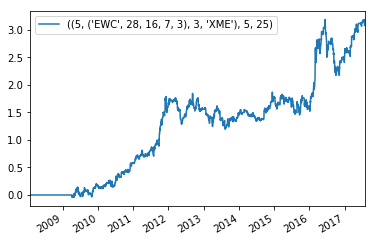

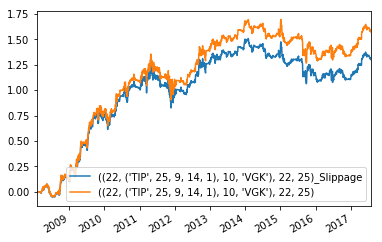

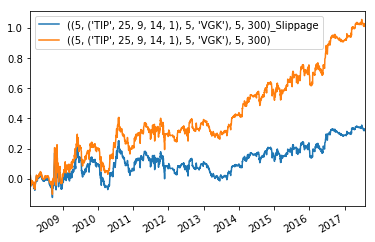

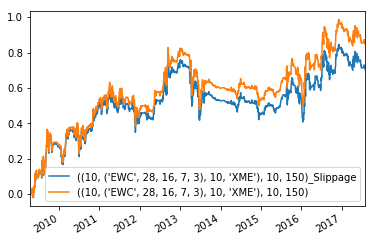

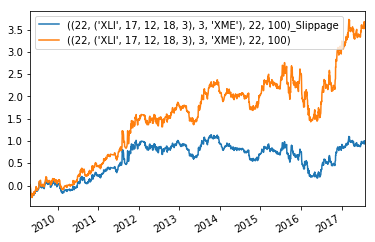

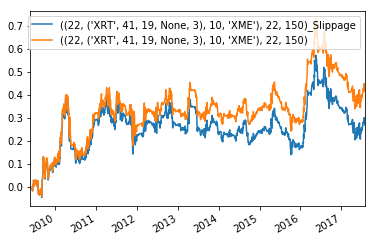

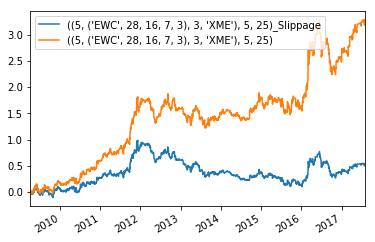

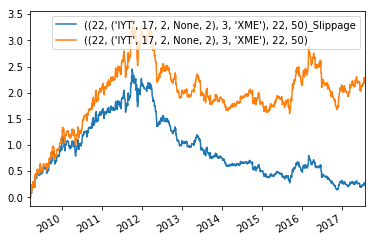

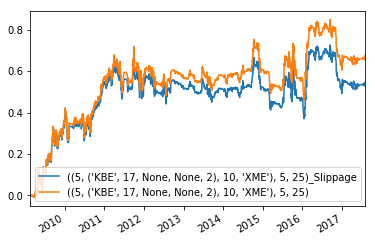

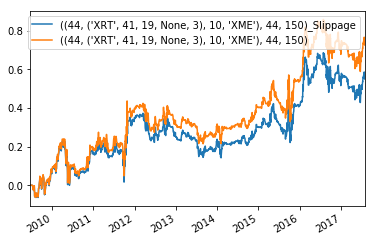

In [14]:
##PERFORM SANITY CHECK
import empyrical
import portfolioGeneration
import matplotlib.pyplot as plt
# empyrical.cum_returns(modelReturns).plot()
plt.show()
for i in range(len(modelReturns.columns)):
    item = modelReturns.columns[i]
#     empyrical.cum_returns(modelReturns[[item]]).plot()
    allocations = modelPredictions[[item]]
    allocations.columns = [uniqueModels[i].inputSeries.targetTicker]
    allocationPerformance, unu, unus = portfolioGeneration.calculatePerformanceForAllocations(allocations, joinedData)
    allocationPerformance.columns = [str(uniqueModels[i].describe()) + "_Slippage"]
    empyrical.cum_returns(allocationPerformance.join(modelReturns[[item]])).plot()
    plt.show()

,"((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)","((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)","((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)","((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)","((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)","((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)","((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)","((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)","((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)",Factor Return
"((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)",1.000000,0.299586,0.361516,0.080119,0.258076,0.145291,0.203028,0.411027,0.080046,0.510203
"((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)",0.299586,1.000000,0.192101,0.029264,0.072288,0.047432,0.098660,0.144577,0.019973,0.270357
"((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)",0.361516,0.192101,1.000000,0.229095,0.382568,0.111080,0.255624,0.458611,0.276160,0.418490
"((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)",0.080119,0.029264,0.229095,1.000000,0.139398,0.096351,0.107538,0.211629,0.082706,0.077791
"((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)",0.258076,0.072288,0.382568,0.139398,1.000000,0.138176,0.282684,0.303221,0.545019,0.389455
"((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)",0.145291,0.047432,0.111080,0.096351,0.138176,1.000000,0.171520,0.223435,0.071180,0.154845
"((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)",0.203028,0.098660,0.255624,0.107538,0.282684,0.171520,1.000000,0.205648,0.120847,0.323344
"((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)",0.411027,0.144577,0.458611,0.211629,0.303221,0.223435,0.205648,1.000000,0.101910,0.359140
"((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)",0.080046,0.019973,0.276160,0.082706,0.545019,0.071180,0.120847,0.101910,1.000000,0.358881
Factor Return,0.510203,0.270357,0.418490,0.077791,0.389455,0.154845,0.323344,0.359140,0.358881,1.000000


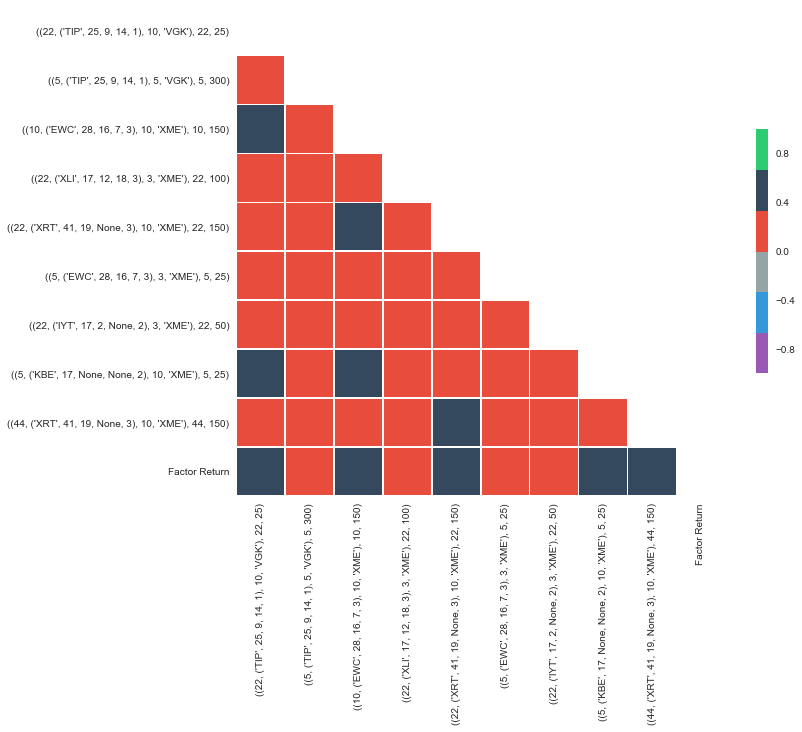

,"((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)","((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)","((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)","((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)","((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)","((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)","((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)","((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)","((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)",Factor Return
"((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)",0.000054,0.000019,0.000024,0.000010,0.000017,0.000013,0.000019,0.000023,0.000006,0.000036
"((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)",0.000019,0.000070,0.000014,0.000004,0.000006,0.000005,0.000010,0.000009,0.000002,0.000022
"((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)",0.000024,0.000014,0.000080,0.000033,0.000031,0.000013,0.000029,0.000031,0.000025,0.000036
"((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)",0.000010,0.000004,0.000033,0.000263,0.000021,0.000020,0.000022,0.000026,0.000014,0.000012
"((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)",0.000017,0.000006,0.000031,0.000021,0.000083,0.000016,0.000032,0.000021,0.000051,0.000034
"((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)",0.000013,0.000005,0.000013,0.000020,0.000016,0.000158,0.000027,0.000021,0.000009,0.000019
"((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)",0.000019,0.000010,0.000029,0.000022,0.000032,0.000027,0.000156,0.000020,0.000015,0.000039
"((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)",0.000023,0.000009,0.000031,0.000026,0.000021,0.000021,0.000020,0.000058,0.000008,0.000026
"((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)",0.000006,0.000002,0.000025,0.000014,0.000051,0.000009,0.000015,0.000008,0.000105,0.000035
Factor Return,0.000036,0.000022,0.000036,0.000012,0.000034,0.000019,0.000039,0.000026,0.000035,0.000092


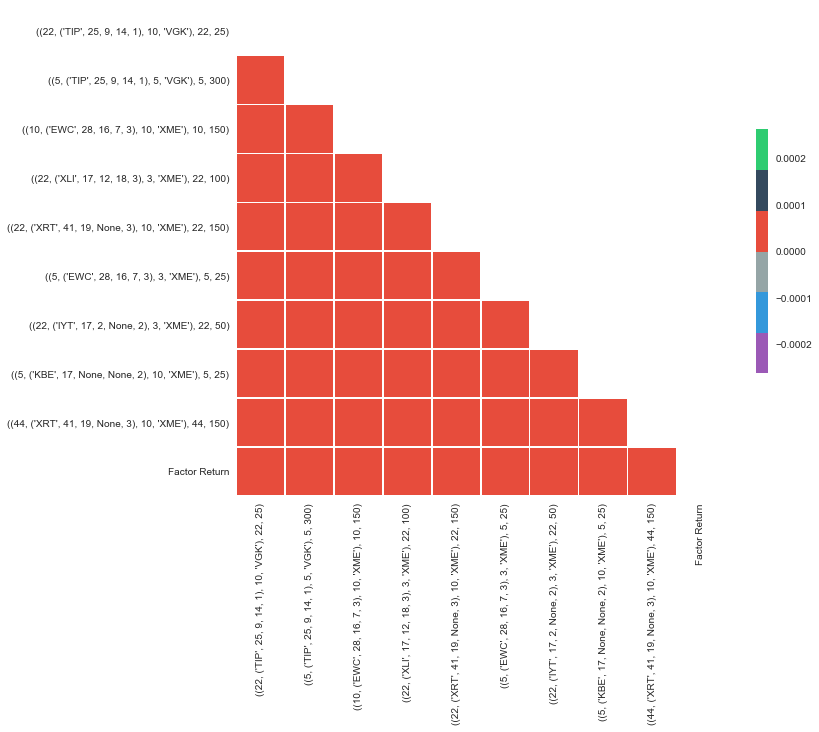

In [10]:
%matplotlib inline
portfolioGeneration.visualizeModels(modelReturnsWithFactor)

In [10]:
portfolioGeneration.storePastPredictions(uniqueModels, modelPredictions)

((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)
NEED TO STORE 1981
((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)
NEED TO STORE 1981
((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)
NEED TO STORE 1981
((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)
NEED TO STORE 1981
((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)
NEED TO STORE 1981
((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)
NEED TO STORE 1981
((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)
NEED TO STORE 1981
((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)
NEED TO STORE 1981
((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)
NEED TO STORE 1981


In [11]:
portfolioHash = portfolioGeneration.storePortfolio(uniqueModels,\
            description="HIGH RELATIVE SHARPE ALLOCATION vs SPY", benchmark=factorToTrade, portfolioType="EW By Ticker")
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
display(portfolioInfo)

PORTFOLIO HASH: 7c76373df7fc8e82ea6e123724190c0f69c0f25e169c139bf3093e6e
1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67
43b82397f03341692c8167a264422c295b817c6251490db92125aa0c
5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1
6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0
85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2
8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780
8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094
9ef7410299afb662c4c52426c6315956a2414567a55a337a35caabbd
e01883a35e1a85df844eb09fa09244b1646c01f0f0eb953e1c26413c


<Entity('walkforward_portfolio_info', '7c76373df7fc8e82ea6e123724190c0f69c0f25e169c139bf3093e6e') {'description': 'HIGH RELATIVE SHARPE ALLOCATION vs SPY', 'portfolioType': 'EW By Ticker', 'benchmark': 'SPY'}>

In [12]:
modelHashes = portfolioGeneration.getPortfolioModels(portfolioHash)
display(modelHashes)

['43b82397f03341692c8167a264422c295b817c6251490db92125aa0c',
 '8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780',
 '8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094',
 'e01883a35e1a85df844eb09fa09244b1646c01f0f0eb953e1c26413c',
 '85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2',
 '6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0',
 '5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1',
 '1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67',
 '9ef7410299afb662c4c52426c6315956a2414567a55a337a35caabbd']

In [13]:
allModels = portfolio.getModelsByKey(modelHashes)
display(allModels)

In [14]:
aggregateReturns, aggregatePredictions = portfolioGeneration.generateAggregateReturnsPredictions(allModels, joinedData)
display(aggregateReturns)

,6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0,e01883a35e1a85df844eb09fa09244b1646c01f0f0eb953e1c26413c,8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094,5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1,85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2,1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67,43b82397f03341692c8167a264422c295b817c6251490db92125aa0c,9ef7410299afb662c4c52426c6315956a2414567a55a337a35caabbd,8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780
2009-05-19,0.012015,NaN,0.012015,-0.000047,0.000392,0.013516,0.012015,NaN,0.001896
2009-05-20,-0.000000,NaN,-0.023192,0.000181,-0.000050,-0.026907,-0.000000,NaN,-0.000325
2009-05-21,-0.000000,NaN,-0.000000,0.000042,0.000514,-0.004303,0.003577,NaN,0.005057
2009-05-22,0.000000,NaN,-0.021902,-0.000428,0.000674,0.026779,-0.043804,NaN,0.015694
2009-05-26,-0.000000,NaN,-0.000000,0.000057,0.000060,-0.002548,0.002071,NaN,-0.015451
2009-05-27,0.000000,NaN,0.000000,-0.000433,-0.000606,0.013689,0.000000,NaN,0.011927
2009-05-28,-0.013426,NaN,0.013426,-0.000734,-0.001599,0.016310,0.013426,NaN,0.017060
2009-05-29,-0.034073,NaN,0.034073,-0.002529,-0.002954,0.040462,0.068146,NaN,0.024398
2009-06-01,-0.002411,NaN,0.000000,-0.000471,-0.001944,0.005575,0.009644,NaN,0.013099
2009-06-02,0.016103,NaN,0.032207,0.004152,0.005528,-0.035729,-0.064413,NaN,-0.032912


In [15]:
cleanedAggregateReturns = aggregateReturns.dropna()
cleanedAggregatePredictions = aggregatePredictions.dropna()
display(cleanedAggregateReturns)
display(cleanedAggregatePredictions)

,6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0,e01883a35e1a85df844eb09fa09244b1646c01f0f0eb953e1c26413c,8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094,5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1,85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2,1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67,43b82397f03341692c8167a264422c295b817c6251490db92125aa0c,9ef7410299afb662c4c52426c6315956a2414567a55a337a35caabbd,8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780
2009-06-19,-0.043757,-0.000171,0.043757,0.023588,-0.009804,0.002735,0.087513,0.049226,-0.034858
2009-06-22,0.000000,0.000101,-0.012883,-0.007096,0.004597,-0.002013,-0.025766,-0.013285,0.011569
2009-06-23,-0.008931,0.000035,-0.017862,-0.004849,0.001186,-0.002163,-0.017862,-0.008443,0.002148
2009-06-24,-0.046888,0.000092,-0.023444,-0.012271,0.007929,-0.007693,-0.046888,-0.019415,0.012377
2009-06-25,0.008905,-0.000017,-0.000000,0.002261,-0.001526,0.001739,0.004453,0.003200,-0.001756
2009-06-26,-0.001586,0.000000,0.000793,-0.000378,0.008099,-0.000365,0.000000,-0.000465,0.006731
2009-06-29,0.011741,-0.000000,-0.023483,0.005091,-0.007180,0.005962,-0.000000,0.005320,-0.005406
2009-06-30,0.000000,-0.000000,0.000000,-0.000000,0.014288,-0.000000,0.000000,-0.000000,0.007495
2009-07-01,-0.000000,0.000158,-0.000000,0.004855,-0.022157,0.007705,-0.000000,0.002322,-0.007272
2009-07-02,-0.000000,0.000504,-0.000000,0.008172,-0.005583,0.014931,0.025826,0.000807,-0.001734


,6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0,e01883a35e1a85df844eb09fa09244b1646c01f0f0eb953e1c26413c,8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094,5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1,85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2,1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67,43b82397f03341692c8167a264422c295b817c6251490db92125aa0c,9ef7410299afb662c4c52426c6315956a2414567a55a337a35caabbd,8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780
2009-06-19,0.50,0.001953,-0.5,-0.269531,0.281250,-0.031250,-1.00,-0.562500,1.0000
2009-06-22,0.00,0.003906,-0.5,-0.275391,0.347656,-0.078125,-1.00,-0.515625,0.8750
2009-06-23,-0.50,0.001953,-1.0,-0.271484,0.414062,-0.121094,-1.00,-0.472656,0.7500
2009-06-24,-1.00,0.001953,-0.5,-0.261719,0.480469,-0.164062,-1.00,-0.414062,0.7500
2009-06-25,-1.00,0.001953,0.0,-0.253906,0.542969,-0.195312,-0.50,-0.359375,0.6250
2009-06-26,-1.00,0.000000,0.5,-0.238281,0.601562,-0.230469,0.00,-0.292969,0.5000
2009-06-29,-0.50,0.000000,1.0,-0.216797,0.664062,-0.253906,0.00,-0.226562,0.5000
2009-06-30,0.00,-0.001953,0.5,-0.203125,0.714844,-0.269531,0.50,-0.152344,0.3750
2009-07-01,0.00,-0.005859,0.0,-0.179688,0.761719,-0.285156,0.00,-0.085938,0.2500
2009-07-02,0.00,-0.009766,0.0,-0.158203,0.804688,-0.289062,-0.50,-0.015625,0.2500


In [37]:
cleanedAggregateReturns

,85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2,6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0,8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780,43b82397f03341692c8167a264422c295b817c6251490db92125aa0c,5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1,1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67,8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094
2009-05-19,0.000392,0.012015,0.001896,0.012015,-0.000047,0.013516,0.012015
2009-05-20,-0.000050,-0.000000,-0.000325,-0.000000,0.000181,-0.026907,-0.023192
2009-05-21,0.000514,-0.000000,0.005057,0.003577,0.000042,-0.004303,-0.000000
2009-05-22,0.000674,0.000000,0.015694,-0.043804,-0.000428,0.026779,-0.021902
2009-05-26,0.000060,-0.000000,-0.015451,0.002071,0.000057,-0.002548,-0.000000
2009-05-27,-0.000606,0.000000,0.011927,0.000000,-0.000433,0.013689,0.000000
2009-05-28,-0.001599,-0.013426,0.017060,0.013426,-0.000734,0.016310,0.013426
2009-05-29,-0.002954,-0.034073,0.024398,0.068146,-0.002529,0.040462,0.034073
2009-06-01,-0.001944,-0.002411,0.013099,0.009644,-0.000471,0.005575,0.000000
2009-06-02,0.005528,0.016103,-0.032912,-0.064413,0.004152,-0.035729,0.032207


In [17]:
portfolioGeneration.getWeightingForAlgos(allModels, cleanedAggregateReturns.columns)

[0.07142857142857144,
 0.07142857142857144,
 0.07142857142857144,
 0.07142857142857144,
 0.25000000000000006,
 0.07142857142857144,
 0.07142857142857144,
 0.07142857142857144,
 0.25000000000000006]

In [18]:
if portfolioInfo["portfolioType"] == "HRP":
    print("HRP")
    ##HRP ALLOCATION
    hrpReturns, historicalWeights = portfolioGeneration.\
            produceHRPPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
            22, startIndex=None, maxWindowSize=True)
    print("COMPUTED HISTORICAL WEIGHTS")
    display(historicalWeights)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
elif portfolioInfo["portfolioType"] == "EW":
    print("EW")
    ##EW ALLOCATION
    ewReturns = portfolioGeneration.produceEWPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
                                     None)
    display(ewReturns)
    historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: [1.0/len(x) for item in x], axis=1), columns=cleanedAggregateReturns.columns.values)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
elif portfolioInfo["portfolioType"] == "EW By Ticker":
    print("EW By Ticker")
    weightArray = portfolioGeneration.getWeightingForAlgos(allModels, cleanedAggregateReturns.columns)
    historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: weightArray, axis=1), columns=cleanedAggregateReturns.columns.values)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
    

EW By Ticker


In [19]:
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
portfolioInfo = {
    "key":portfolioInfo.key.name,
    "description":portfolioInfo["description"],
    "benchmark":portfolioInfo["benchmark"],
    "portfolioType":portfolioInfo["portfolioType"]
}
print(portfolioInfo)
portfolioData = portfolioGeneration.getDataForPortfolio(portfolioHash, factorToTrade, joinedData)
portfolioGeneration.cachePortfolio(portfolioInfo, portfolioData)

{'key': '7c76373df7fc8e82ea6e123724190c0f69c0f25e169c139bf3093e6e', 'description': 'HIGH RELATIVE SHARPE ALLOCATION vs SPY', 'benchmark': 'SPY', 'portfolioType': 'EW By Ticker'}
((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)
((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)
((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)
((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)
((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)
((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)
((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)
((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)
((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)
